In [1]:
import os, sys, csv, gzip
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy import io

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
%matplotlib inline

from plots import COLORS10, enlarge_tick_fontsize
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import (StratifiedKFold, cross_val_score)
from sklearn.metrics import *
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble
from sklearn.pipeline import Pipeline
import xgboost as xgb

# 1. Prepare the gene/feature attribute matrices and target class to for supervised machine learning

Load known  P53 targets components from file

In [2]:
df_labels = pd.read_csv('data/components.csv')
print df_labels.shape
df_labels.head()

(63, 1)


,Official Symbol
0,S100A10
1,S100A11
2,TCHHL1
3,TCHH
4,RPTN


These files below were downloaded from [Harmonizome](http://amp.pharm.mssm.edu/Harmonizome/) as the features for genes to predict whether they are adhesome components. 

There are two types datasets: continues and binary. Continues datasets were standardized.    

In [3]:
filenames = [
        #'InterPro_gene_attribute_matrix.txt.gz', 
        #'ENCODE-TF_gene_attribute_matrix.txt.gz',
        'CCLE-GE_gene_attribute_matrix_standardized.txt.gz',
        'Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz',
        'Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz'
    ]
basenames = [f.split('_')[0] for f in filenames]
are_continues = ['_standardized' in f for f in filenames]

In [4]:
def read_gene_attribute_matrix(fn):
	'''
	Reads a gzipped file downloaded from Harmonizome into a pandas.DataFrame,
	with GeneSym as index. 
	'''
	with gzip.open(fn) as f:
		reader = csv.reader(f, delimiter='\t')
		header = reader.next()
		header[0] = 'GeneSym'
		# Skip line 2, 3
		reader.next()
		reader.next()

		# Remove the second and third columns which are meta data for GeneSym
		header[1:3] = []

		i = 0
		df = []

		if '_standardized' in fn: # continues
			for row in reader:
				row[1:3] = []
				row[1:] = map(float, row[1:])
				df.append(dict(zip(header, row)))
				i += 1
				if i % 2000 == 0:
					print i
			df = pd.DataFrame().from_records(df)[header]
			df.set_index('GeneSym', inplace=True, verify_integrity=True)
					
		else: # convert values to int and make sparse df
			for row in reader:
				row[1:3] = []
				row[1:] = map(lambda x: int(float(x)), row[1:])

				d = {h: v for h, v in zip(header, row) if v != 0}
				df.append(d)
				i += 1
				if i % 2000 == 0:
					print i
			df = pd.DataFrame().from_records(df)[header]\
				.set_index('GeneSym', verify_integrity=True)\
				.to_sparse(fill_value=0)
		
	return df

In [5]:
## Parse data files downloaded from Harmonizome 
dfs = []
for fn in filenames:
    df = read_gene_attribute_matrix('data/%s' % fn)
    print fn, df.shape
    dfs.append(df)

2000
4000
6000
8000
10000
12000
14000
16000
18000
CCLE-GE_gene_attribute_matrix_standardized.txt.gz (18046, 1037)
2000
4000
6000
8000
10000
12000
14000
16000
Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz (17979, 414)
2000
4000
6000
8000
10000
12000
14000
Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz (15072, 524)


In [6]:
#dfs

In [7]:
#dfs[dfs== np.nan] = str(0.0)


In [8]:
#df_labels[y>0]

In [9]:
## INNER JOIN all feature dfs 
df_joined = reduce(lambda a, b: pd.merge(a, b, left_index=True, right_index=True, how='outer'), 
           dfs)
print df_joined.shape

(21155, 1975)


In [10]:
df_joined.replace(np.nan, 0.0, inplace=True)
df_joined.replace(np.inf, 0.0, inplace=True)

In [11]:
#'FLG' in df_joined.index.sort_values()

In [12]:
## Create y 
RNG = 2016
y = np.in1d(df_joined.index, df_labels['Official Symbol']).astype(np.int8)
print y.sum()
## Make CV
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=RNG)
## Export y
df_labels = pd.DataFrame({'y': y, 'GeneSym': df_joined.index}).set_index('GeneSym')
print df_labels.shape
df_labels.to_csv('data/P53_targets.csv')
df_labels.head()

56
(21155, 1)


,y
GeneSym,
A1BG,0
A1BG-AS1,0
A1CF,0
A2M,0
A2M-AS1,0


In [13]:
## Keep only the shared genes across the 4 datasets
dfs = [df.ix[df_joined.index] for df in dfs]

In [14]:
## Export processed matrices in dfs
feature_names = {} # To store feature names
i = 0
for basename, df in zip(basenames, dfs):
    feature_names[basename] = df.columns.tolist()
    if are_continues[i]:
        np.save('data/%s_shared' % basename, df.values)
    else: # sparse matrix
        io.mmwrite('data/%s_shared.mtx' % basename, sp.csr_matrix(df.values))
    i += 1

del df_joined
del dfs, df

# 2. Load preprocessed matrices and perform classifications

In [17]:
# Load from matrices files generated above
Xs = []
for i, basename in enumerate(basenames):
    if are_continues[i]:
        Xs.append(np.load('data/%s_shared.npy' % basename))
    else:
        Xs.append(io.mmread('data/%s_shared.mtx' % basename).tocsr())

df_labels = pd.read_csv('data/P53_targets.csv')
y = df_labels['y'].values
ratio = float(np.sum(y == 0)) / np.sum(y==1)
print 'Number of known P53 components: %d' % y.sum()
print 'Ratio of negative labels over positive labels: %.4f' % ratio

Number of known adhesome components: 56
Ratio of negative labels over positive labels: 376.7679


Perform dimentionality reduction using `TruncatedSVD` for all the matrices

In [18]:
#Xs[1] = np.nan_to_num(Xs[1])

In [19]:
#Xs

In [20]:
all_loadings = [] # collect loading matrices from SVD
for i, basename in enumerate(basenames):
    print i
    svd = TruncatedSVD(n_components=60, random_state=RNG)
    Xs[i] = np.nan_to_num(Xs[i])
    Xs[i] = svd.fit_transform(Xs[i])
    all_loadings.append(svd.components_)    

X_combined = np.hstack(Xs)

0
1
2


In [21]:
## Helper functions for evaluating classifiers
def cross_val_predictions(est, X, y, cv):
	'''to get out-of-sample predictions and scores'''
	y_preds = np.zeros(y.shape)
	y_probas = np.zeros(y.shape)
	for train_idx, valid_idx in cv:
		print X[train_idx].shape, y[train_idx].shape
		est.fit(X[train_idx], y[train_idx])
		y_preds[valid_idx] = est.predict(X[valid_idx])
		y_probas[valid_idx] = est.predict_proba(X[valid_idx])[:,1]
	return y_preds, y_probas


def plot_roc(ests, Xs, y, cv, ax, colors=None, labels=None):
	all_labels = []
	total = len(labels)

	if type(ests) == list and type(Xs) != list:
		total = len(ests)
		Xs = [Xs]*total
	elif type(ests) != list and type(Xs) == list:
		ests = [ests]*total
	
	for i in range(total):
		X = Xs[i]
		est = ests[i]
		
		label = labels[i]
		color = colors[i]
		all_labels.extend([label] * len(cv))

		y_preds, y_probas = cross_val_predictions(est, X, y, cv)
		fpr, tpr, _ = roc_curve(y, y_probas)
		score = auc(fpr, tpr)
		ax.plot(fpr, tpr, label=label + ' (AUC=%.3f)' % score, color=color, lw=2)

	ax.set_xlabel('False Positive Rate', fontsize=16)
	ax.set_ylabel('True Positive Rate', fontsize=16)

	enlarge_tick_fontsize(ax, 12)
	ax.legend(loc='lower right')
	return

Estimate the number of rounds of boosting using early stopping for a single feature matrix InterPro: The boosting classifier will stop if the validation score does not improve in 50 rounds.

In [22]:
dtrain = xgb.DMatrix(Xs[0], label=y)

param = {
    'max_depth':10, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.6,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round, early_stopping_rounds=50, metrics='auc', seed=RNG, verbose_eval=10)

print scores.tail()


[0]	train-auc:0.859278+0.0463089	test-auc:0.727542+0.0285119
[10]	train-auc:0.899225+0.011348	test-auc:0.751531+0.0241969
[20]	train-auc:0.901956+0.0113729	test-auc:0.794142+0.0244536
[30]	train-auc:0.912053+0.00369958	test-auc:0.801494+0.0403057
[40]	train-auc:0.926038+0.00653248	test-auc:0.80962+0.0332806
[50]	train-auc:0.938931+0.00733524	test-auc:0.812465+0.0378645
[60]	train-auc:0.951388+0.00154893	test-auc:0.820051+0.0337167
[70]	train-auc:0.95126+0.0107033	test-auc:0.822755+0.0332268
[80]	train-auc:0.969021+0.00670305	test-auc:0.824242+0.0299275
[90]	train-auc:0.973727+0.00336903	test-auc:0.825047+0.0326471
[100]	train-auc:0.97262+0.00402313	test-auc:0.821371+0.0346602
[110]	train-auc:0.974028+0.00364259	test-auc:0.819634+0.0351483
[120]	train-auc:0.975114+0.00235569	test-auc:0.818627+0.0372819
[130]	train-auc:0.976235+0.00157172	test-auc:0.818085+0.0386797
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
79       0.824648      0.030005        0.967903       0.0078

Estimate the number of rounds of boosting using early stopping for the combined feature matrix.

In [23]:
dtrain = xgb.DMatrix(X_combined, label=y)

param = {
    'max_depth':12, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.4,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round,
    early_stopping_rounds=50,
    metrics='auc', seed=RNG,
    verbose_eval=10)

print scores.tail()


[0]	train-auc:0.793219+0.0716136	test-auc:0.619681+0.00595549
[10]	train-auc:0.994644+0.00350208	test-auc:0.823023+0.0183975
[20]	train-auc:0.998856+0.000366864	test-auc:0.878957+0.0156689
[30]	train-auc:0.999455+8.82962e-05	test-auc:0.870775+0.0169474
[40]	train-auc:0.999747+0.000142535	test-auc:0.886858+0.0163288
[50]	train-auc:0.999866+0.000101128	test-auc:0.890409+0.017654
[60]	train-auc:0.999903+6.71863e-05	test-auc:0.891436+0.0123157
[70]	train-auc:0.999914+7.26147e-05	test-auc:0.90293+0.0141014
[80]	train-auc:0.999929+8.05523e-05	test-auc:0.903525+0.0140988
[90]	train-auc:0.999925+8.12171e-05	test-auc:0.903616+0.020635
[100]	train-auc:0.999945+4.62913e-05	test-auc:0.898709+0.0151519
[110]	train-auc:0.999952+4.76818e-05	test-auc:0.895329+0.0122913
[120]	train-auc:0.999959+4.39267e-05	test-auc:0.894231+0.0102951
[130]	train-auc:0.999967+3.87929e-05	test-auc:0.89472+0.00785571
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
83       0.902051      0.016227        0.99

Plot the ROC curves to evaluate the predictive performance of the GBM classifiers

(14103, 60) (14103,)
(14103, 60) (14103,)
(14104, 60) (14104,)
(14103, 60) (14103,)
(14103, 60) (14103,)
(14104, 60) (14104,)
(14103, 60) (14103,)
(14103, 60) (14103,)
(14104, 60) (14104,)
(14103, 180) (14103,)
(14103, 180) (14103,)
(14104, 180) (14104,)


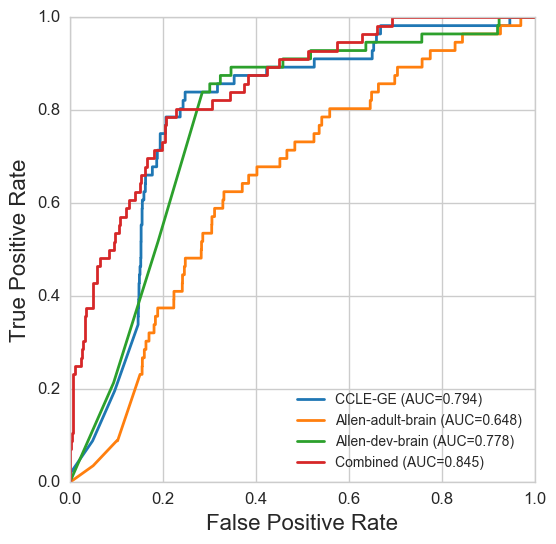

In [24]:
Xs.append(X_combined)
basenames.append('Combined')

# optimized GBM classifiers
xgbc = xgb.XGBClassifier(seed=RNG, n_estimators=39, learning_rate=0.05,
    max_depth=10, colsample_bytree=0.6, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=159, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

clfs = [xgbc] * 5 + [xgbc2]

fig, ax = plt.subplots(figsize=(6,6))
plot_roc(clfs, Xs, y, cv, ax, colors=COLORS10, labels=basenames)

# 3. Apply the GBM classifier to all the datasets to generate predictions 

In [25]:
RNG = 20160628
xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=160, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=8, silent=True, scale_pos_weight=ratio)

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=RNG)

## Get out-of-fold predictions
y_preds, y_probas = cross_val_predictions(xgbc2, X_combined, y, cv)

## Get predictions on training fold
xgbc2.fit(X_combined, y)
y_probas_on_train = xgbc2.predict_proba(X_combined)[:, 1]


(19039, 180) (19039,)
(19039, 180) (19039,)
(19039, 180) (19039,)
(19039, 180) (19039,)
(19039, 180) (19039,)
(19039, 180) (19039,)
(19040, 180) (19040,)
(19040, 180) (19040,)
(19040, 180) (19040,)
(19041, 180) (19041,)


In [26]:
df_labels['OOF_preds'] = y_preds
df_labels['OOF_probas'] = y_probas
df_labels['train_probas'] = y_probas_on_train

df_labels[df_labels['OOF_preds'] != 0].sort_values('OOF_probas', ascending=False).to_csv('Results', index=False, sep='\t')
#df_labels.sort_values('OOF_preds', ascending=False)

In [27]:
df_labels.to_csv('P53_targets _on_combined_predictions.csv')

# 4. Interpret the classifier by feature importance

In [28]:
## Get the feature_importances_ from the fitted GBM
feature_importances = xgbc2.feature_importances_
print feature_importances.shape

(180,)


In [29]:
## Count the number of original features
n_features = sum(map(len, feature_names.values()))
print 'There are %d features across these datasets used for the prediction' % n_features

There are 1975 features across these datasets used for the prediction


Map feature importances on the SVD components back to original feature space by dot product between the feature importance vector and the loading matrix:

In [30]:
all_feature_names = []
all_feature_fis = []
datasets = []
for i, basename in enumerate(basenames[:-1]):
    fi = feature_importances[i*60:(i+1)*60]
    loadings = all_loadings[i]
    original_feature_fis = np.dot(fi, loadings)
    original_feature_names = feature_names[basename]
    
    datasets.extend([basename] * len(original_feature_names))
    all_feature_fis.extend( original_feature_fis.tolist() )
    all_feature_names.extend( original_feature_names )

# Create a DataFrame of feature importances
df_feature_importances = pd.DataFrame({
        'dataset': datasets,
        'feature': all_feature_names, 
        'feature_importance': all_feature_fis})    

Examine the most predictive features for adhesome components:

In [31]:
df_feature_importances.sort('feature_importance', ascending=False).head(20)

/Users/moshesilverstein/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dataset,feature,feature_importance
1083,Allen-adult-brain,"Crus I, right, lateral hemisphere",0.012107
1427,Allen-adult-brain,"pontine nuclei, right",0.011936
1428,Allen-adult-brain,"arcuate nucleus of medulla, right",0.011865
1084,Allen-adult-brain,"IX, right, paravermis",0.010571
1426,Allen-adult-brain,"pontine nuclei, left",0.010322
1425,Allen-adult-brain,"arcuate nucleus of medulla, left",0.008498
1429,Allen-adult-brain,"cochlear nuclei, right",0.007905
1365,Allen-adult-brain,"principal sensory nucleus of trigeminal nerve,...",0.007327
1354,Allen-adult-brain,"interstitial nucleus of Cajal, right",0.006846
1350,Allen-adult-brain,"oculomotor nuclear complex, right",0.006763


Examine the most predictive features in ENCODE-TF dataset for adhesome components:

In [38]:
cancer_import = df_feature_importances.query('dataset == "CCLE-GE"').sort('feature_importance', ascending=False).head(10)

/Users/moshesilverstein/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [39]:
cancer_import

,dataset,feature,feature_importance
720,CCLE-GE,RKO,0.006085
719,CCLE-GE,NCIH1915,0.005406
148,CCLE-GE,ZR751,0.005294
632,CCLE-GE,SH4,0.005062
449,CCLE-GE,NCIH1563,0.004854
689,CCLE-GE,SLR20,0.004844
715,CCLE-GE,SW1990,0.004801
312,CCLE-GE,CORL105,0.004672
718,CCLE-GE,NCIH838,0.004668
349,CCLE-GE,SNU668,0.004526


Write the full feature importance table to a file and provide a link to this file.

In [33]:
df_feature_importances.to_csv('feature_importances.csv')

from IPython.display import FileLink
FileLink('feature_importances.csv')

/Users/moshesilverstein/Desktop/untitled folder/feature_importances.csv

In [36]:
metadata = pd.read_csv('attribute_list_entries.txt', sep='\t')

In [44]:
metadata.set_index('CellLine', inplace=True)
metadata.head()

,Tissue,NA
CellLine,,
CHL1,skin,na
HMCB,skin,na
HS852T,skin,na
HS695T,skin,na
A101D,skin,na


In [42]:
cancer_import.insert(2, 'Tissue', np.nan)

In [45]:
cancer_import.set_index('feature', inplace=True)
for cell in cancer_import.index:
    for comp in metadata.index:
        if cell == comp:
            cancer_import.ix[cell, 'Tissue'] = metadata.ix[comp, 'Tissue']

In [47]:
cancer_import.reset_index(inplace=True)

In [48]:
cancer_import

,feature,dataset,Tissue,feature_importance
0,RKO,CCLE-GE,large intestine,0.006085
1,NCIH1915,CCLE-GE,lung,0.005406
2,ZR751,CCLE-GE,breast,0.005294
3,SH4,CCLE-GE,skin,0.005062
4,NCIH1563,CCLE-GE,lung,0.004854
5,SLR20,CCLE-GE,kidney,0.004844
6,SW1990,CCLE-GE,pancreas,0.004801
7,CORL105,CCLE-GE,lung,0.004672
8,NCIH838,CCLE-GE,lung,0.004668
9,SNU668,CCLE-GE,stomach,0.004526
